# IMPORT LIBRARIES

In [279]:
# MACHINE LEARNING
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import (r2_score, roc_auc_score,
                             classification_report, confusion_matrix,
                             roc_curve, accuracy_score, mean_squared_error)

# SOUND MANIPULATION
import soundfile as sf
from soundfile import SoundFile

# AUDIO ANALISIS
import librosa
import librosa.display
from scipy.fft import fft, rfftfreq, rfft
from scipy.stats import kurtosis
import antropy as ant

# FILTERS
from pedalboard import LadderFilter, Pedalboard

# DATA MANIPULATION
import numpy as np
import pandas as pd
import math

# DATA PLOT
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD INSTRUMENTS

### NUMERO DE SAMPLES POR INSTRUMENTO

In [280]:
numSounds = 50

### INSTRUMENTOS 

In [281]:
instruments = ["Kick", "Snare", "Hihat", "Guitar", "Bass", "Vox"]

### GENERAL DATA

In [282]:
generalPath = "../InstrumentsClassifier/Instruments/"

instrumentsAudio = []
for instrument in instruments:
    instrumentPath = generalPath + instrument + "/"
    sound = []
    
    for i in range(numSounds):
        path = instrumentPath + instrument + "_" + str(i+1) + ".wav"
        audio = SoundFile(path)

        if audio.channels == 1:
            samples, sr = sf.read(path)
            sound.append([samples, sr])
        else:
            samples, sr = sf.read(path)
            sound.append([samples[:,0], sr])
            
    instrumentsAudio.append([instrument, sound])
    
# 0 = INSTRUMENTO (0 - n Instrumentos)
# 1 = NOMBRE DE INSTRUMENTO O ARREGLO (0 o 1)
# 2 = SELECCIONAR QUE SAMPLE SE QUIERE (0 - n Samples)
# 3 = SELECCIONAR SAMPLES O SAMPLE RATE (0 o 1)

# SEE AND ANALIZE SOUNDS

### AUDIO IN TIME DOMAIN

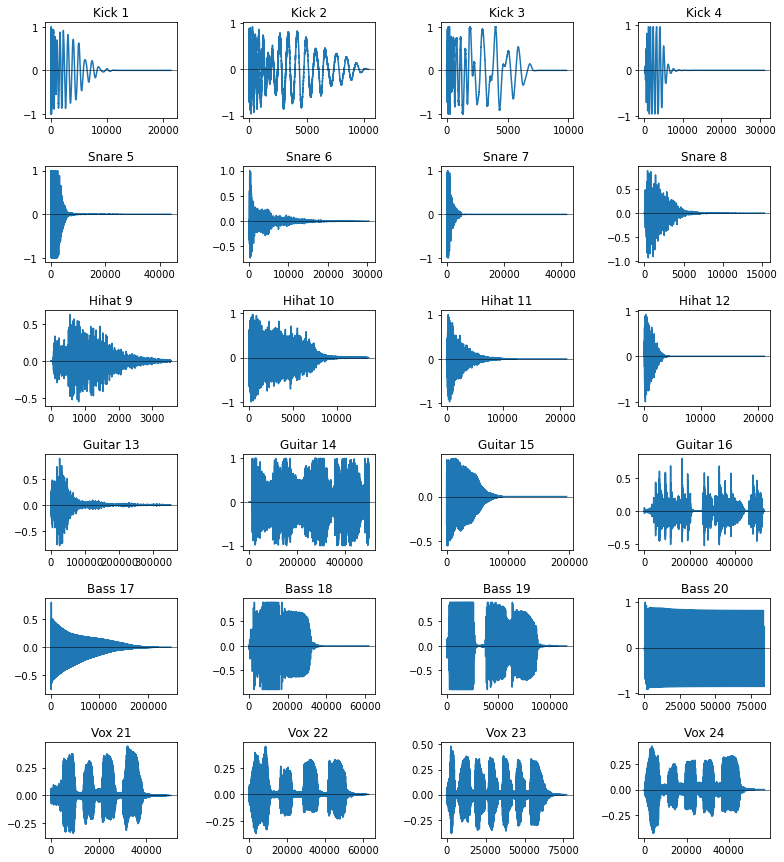

In [283]:
inTime = plt.figure("Time Domain", figsize=(13,15))
inTime.subplots_adjust(hspace=0.5, wspace=0.5)

instrument = 0
for i in range(1, (len(instruments)*4) + 1):
    ax = inTime.add_subplot(len(instruments), 4, i)
    ax.plot(instrumentsAudio[instrument][1][i][0])
    ax.set_title(instruments[instrument] + " " + str(i))
    ax.axhline(0, color='black', linewidth=0.5)
    
    if i % 4 == 0:
        instrument += 1

plt.show()

### AUDIO IN FREQUENCY DOMAIN

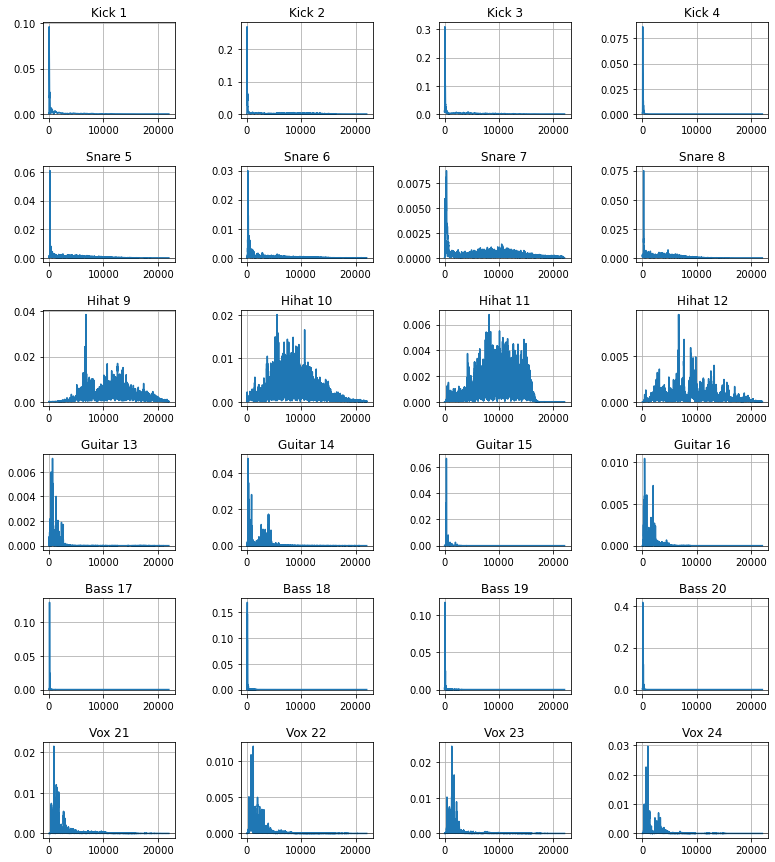

In [284]:
inFrequency = plt.figure("Frequency Domain", figsize=(13,15))
inFrequency.subplots_adjust(hspace=0.5, wspace=0.5)

instrument = 0
for i in range(1, (len(instruments)*4) + 1):
    samples = instrumentsAudio[instrument][1][i][0]
    sr = instrumentsAudio[instrument][1][i][1]
    
    N = len(samples)
    T = 1/sr
    yf = fft(samples)
    xf = fftfreq(N, T)[:N//2]
    
    ax = inFrequency.add_subplot(len(instruments), 4, i)
    ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax.set_title(instruments[instrument] + " " + str(i))
    ax.grid()
    ax.axhline(0, color='black', linewidth=0.5)
    
    if i % 4 == 0:
        instrument += 1
        
plt.show()

# PRE PROCESSING

### CALCULATE CENTROID FOR ALL THE SOUNDS

In [11]:
kicks_centroid = []
snares_centroid = []
hihats_centroid = []
guitars_centroid = []

cont = 0
for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    kicks_centroid.append(centroid)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    snares_centroid.append(centroid)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    hihats_centroid.append(centroid)
    
for guitar in guitars:
    amplitude = np.abs(rfft(guitar[0]))
    frequency = rfftfreq(len(guitar[0]), 1 / guitar[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    guitars_centroid.append(centroid)

print("Instrument:", guitars_centroid)

Instrument: [2067.2182953615797, 971.7122630706654, 2175.9900361749524, 2298.647100280113, 4172.693280872488, 4280.405238274479, 4139.058366523015, 1471.0684617760419, 2504.6730508000846, 1745.7493813593755, 1142.0621485060308, 1067.2626537095998, 1313.2291952893781, 1083.9363996257484, 2651.2081965949887, 826.6719202260253, 1659.8689625729683, 1445.3576830209256, 1717.228177450321, 1526.2105855256464, 1628.5534177248571, 1869.644925474004, 1710.0181728427237, 2035.011242857067, 1619.2141208849941, 2233.700918097664, 2409.8898015462896, 2287.312299414072, 2040.3341879857596, 1883.0356562893526, 1879.2043460383343, 1704.7554495569793, 2319.024120322133, 1475.489274886016, 1556.2998131085824, 1668.7189842856778, 1034.546878915588, 2181.701894820413, 559.2776997002152, 1652.7963169360899, 2053.802702014524, 1546.1243814856139, 5301.225124151047, 1663.4931531905793, 1790.7071569452721, 632.553824496908, 672.7269441297498, 683.6834211150851, 530.3916597972357, 1439.6182851546978]


### CALCULATE SPREAD

In [12]:
kicks_spread = []
snares_spread = []
hihats_spread = []
guitars_spread = []

def spectralSpread(inFrequency, inAmplitude, inCentroid):
    i = 0
    numerator = 0
    denominator = 0
    for frequency in inFrequency:
        numerator += (frequency - inCentroid) ** 2 * inAmplitude[i]
        denominator += inAmplitude[i]
        i += 1
    return math.sqrt(numerator / denominator)

for kick in kicks:
    amplitude = np.abs(rfft(kick[0]))
    frequency = rfftfreq(len(kick[0]), 1 / kick[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    kicks_spread.append(spread)

for snare in snares:
    amplitude = np.abs(rfft(snare[0]))
    frequency = rfftfreq(len(snare[0]), 1 / snare[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    snares_spread.append(spread)
    
for hihat in hihats:
    amplitude = np.abs(rfft(hihat[0]))
    frequency = rfftfreq(len(hihat[0]), 1 / hihat[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    hihats_spread.append(spread)
    
for guitar in guitars:
    amplitude = np.abs(rfft(guitar[0]))
    frequency = rfftfreq(len(guitar[0]), 1 / guitar[1])
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    spread = spectralSpread(frequency, amplitude, centroid)
    guitars_spread.append(spread)

print("Instrument:", guitars_spread)

Instrument: [1780.728777136958, 1506.8647626918998, 1771.3548386115965, 1858.6891608211338, 4518.997004538873, 4499.324105932673, 4380.027694194762, 1976.1887316723032, 2646.623155768237, 1578.3467409398438, 1186.039293105764, 1410.93184110435, 1983.2170087493732, 1229.8983139207357, 2040.5078135151493, 1905.4457923332989, 1306.0651195013356, 1696.5918501834972, 1636.3222049248216, 1109.4845256689268, 1135.8001637452373, 1142.3624882341958, 1057.7167675433875, 1416.0833681977822, 1279.4988134139599, 1463.0713411437912, 1231.0959325237197, 1640.09436645708, 1719.8034341307539, 1653.432921170242, 1676.989770421631, 1568.595878521969, 1808.503815235594, 1966.7110320437102, 1536.640189879959, 1856.6533814901165, 1126.1705937691447, 3248.4953013671593, 1905.3130002465, 1981.4540215850484, 1876.8027887050812, 1192.2635517990432, 4959.462420770991, 1519.7945250918297, 2137.874434728721, 930.7658499595899, 820.5416334908748, 850.4944682266226, 774.1671634270086, 1268.5127712417154]


### CALCULATE AND APPLY FILTERS

In [13]:
def highPassProcess(inAudio, inCutoff, inSr):
    board = Pedalboard([LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=inCutoff)], sample_rate=inSr)
    inAudio = board(inAudio)
    return inAudio

def LowPassProcess(inAudio, inCutoff, inSr):
    board = Pedalboard([LadderFilter(mode=LadderFilter.Mode.LPF12, cutoff_hz=inCutoff)], sample_rate=inSr)
    inAudio = board(inAudio)
    return inAudio

def makeFilters(inSamples, inLow, inHigh):
    inSamples[0] = highPassProcess(inSamples[0], inHigh, inSamples[1])
    inSamples[0] = LowPassProcess(inSamples[0], inLow, inSamples[1])
    return inSamples[0]

cont = 0
for kick in kicks:
    # OBTAIN HIGH AND LOW CUT
    lowCut = kicks_centroid[cont] + kicks_spread[cont]
    highCut = kicks_centroid[cont] - kicks_spread[cont]
    if highCut < 20:
        highCut = 20
    kick[0] = makeFilters(kick, lowCut, highCut)
    cont += 1
    
cont = 0
for snare in snares:
    # OBTAIN HIGH AND LOW CUT
    lowCut = snares_centroid[cont] + snares_spread[cont]
    highCut = snares_centroid[cont] - snares_spread[cont]
    if highCut < 20:
        highCut = 20
    snare[0] = makeFilters(snare, lowCut, highCut)
    cont += 1

cont = 0
for hihat in hihats:
    # OBTAIN HIGH AND LOW CUT
    lowCut = hihats_centroid[cont] + hihats_spread[cont]
    highCut = hihats_centroid[cont] - hihats_spread[cont]
    if highCut < 20:
        highCut = 20
    hihat[0] = makeFilters(hihat, lowCut, highCut)
    cont += 1
    
cont = 0
for guitar in guitars:
    # OBTAIN HIGH AND LOW CUT
    lowCut = guitars_centroid[cont] + guitars_spread[cont]
    highCut = guitars_centroid[cont] - guitars_spread[cont]
    if highCut < 20:
        highCut = 20
    guitar[0] = makeFilters(guitar, lowCut, highCut)
    cont += 1

# OBTAIN DATA

### FUNCTIONS TO USE IN ORDER TO OBTAIN AUDIO DESCRIPTORS

In [285]:
def getAmplitude(inSamples):
    return(np.abs(rfft(inSamples)))

def getFrequency(inSamples, inSampleRate):
    return(rfftfreq(len(inSamples), 1 / inSampleRate))

def getCentroid(inSamples, inSampleRate):
    amplitude = getAmplitude(inSamples)
    frequency = getFrequency(inSamples, inSampleRate)
    centroid = np.sum(amplitude * frequency) / np.sum(amplitude)
    return centroid

def getPeak(inSamples, inSampleRate):
    amplitude = getAmplitude(inSamples)
    frequency = getFrequency(inSamples, inSampleRate)
    peakIndex = np.argmax(np.array(amplitude))
    peak = frequency[peakIndex]
    return peak

def getSpread(inSamples, inSampleRate):
    amplitude = getAmplitude(inSamples)
    frequency = getFrequency(inSamples, inSampleRate)
    centroid = getCentroid(inSamples, inSampleRate)
    
    i, numerator, denominator = 0, 0, 0

    for frequencies in frequency:
        numerator += (frequencies - centroid) ** 2 * amplitude[i]
        denominator += amplitude[i]
        i += 1
    
    return math.sqrt(numerator / denominator)

def getMFCC(inSamples, inSampleRate):
    mfccValue = librosa.feature.mfcc(inSamples, sr=inSampleRate, n_mfcc=13)
    return mfccValue

def getZeroCrossing(inSamples):
    zero_crossing = librosa.feature.zero_crossing_rate(inSamples)
    return zero_crossing.mean()

def getKurtosis(inSamples):
    return kurtosis(inSamples, fisher=True)

def getEntropy(inSamples, inSampleRate):
    return ant.spectral_entropy(inSamples, inSampleRate, method='welch', normalize=True)

def getRollOff(inSamples, inSampleRate):
    return librosa.feature.spectral_rolloff(inSamples, inSampleRate).mean()

def getDecrease(inSamples):
    amplitude = getAmplitude(inSamples)
    primero = amplitude[0]
    amplitude = np.delete(amplitude,0)
    decrease = np.sum(amplitude - primero) / ((len(amplitude)-1) * np.sum(amplitude))
    return decrease

def getSlope(inSamples, inSampleRate):
    amplitude = getAmplitude(inSamples)
    frequency = getFrequency(inSamples, inSampleRate)
    slope = np.sum((amplitude - amplitude.mean()) * (frequency - frequency.mean())) / np.sum((frequency - frequency.mean()) ** 2)
    return slope

def getFlatness(inSamples):
    return librosa.feature.spectral_flatness(inSamples).mean()

def getFlux(inSamples):
    return librosa.onset.onset_strength(inSamples).mean()

### MAKE DESCRIPTORS

In [286]:
descriptors = ['Instrument', 'ID', 'Centroid', 'Peak', 'Spread', 'Zero Crossing', 'Kurtosis', 'Entropy', 'Roll Off', 'Decrease', 'Slope', 
               'Flatness', 'Flux', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 
               'MFCC_11', 'MFCC_12', 'MFCC_13']

In [287]:
sounds_info = []

cont = 0
for instrument in instruments:
    sound = []
    
    for i in range(numSounds):    
        fila = []
        samples = instrumentsAudio[cont][1][i][0]
        sr = instrumentsAudio[cont][1][i][1]
        
        fila.append(instrument)
        fila.append(cont+1)
        fila.append(getCentroid(samples, sr))       
        fila.append(getPeak(samples, sr))
        fila.append(getSpread(samples, sr))
        fila.append(getZeroCrossing(samples))
        fila.append(getKurtosis(samples))
        fila.append(getEntropy(samples, sr))
        fila.append(getRollOff(samples, sr))
        fila.append(getDecrease(samples))
        fila.append(getSlope(samples, sr))
        fila.append(getFlatness(samples))
        fila.append(getFlux(samples))
        for mfcc in getMFCC(samples, sr):
            fila.append(mfcc.mean())
        
        sounds_info.append(fila)
        
    cont += 1

datos = pd.DataFrame(sounds_info, columns=descriptors)
datos

,Instrument,ID,Centroid,Peak,Spread,Zero Crossing,Kurtosis,Entropy,Roll Off,Decrease,...,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,Kick,1,2284.889218,55.799241,4254.374655,0.229167,4.343103,0.223988,13013.745117,-1.104418e-04,...,26.300107,15.612092,15.320112,13.639032,10.132375,8.596697,6.806134,4.950433,4.627034,3.634569
1,Kick,1,2362.052887,41.332771,3896.753265,0.145299,2.714435,0.227075,7665.307617,6.781112e-05,...,23.282166,15.530210,15.536198,13.668951,12.264386,10.924024,9.508763,8.374239,7.274329,6.836314
2,Kick,1,4167.864858,55.215256,4945.284352,0.016416,-0.518008,0.265309,8790.673828,1.543427e-04,...,66.378865,-1.690028,53.169769,14.025547,33.162269,13.193295,30.112873,5.838897,21.613707,10.176115
3,Kick,1,3424.106537,44.798862,4233.750465,0.008008,0.302934,0.318925,1779.719238,-8.416776e-04,...,51.623323,23.934731,29.565948,18.305654,20.092091,10.998468,13.782512,9.837214,8.859652,6.960671
4,Kick,1,114.889174,49.582396,193.671907,0.098137,6.944969,0.148212,8249.687820,-1.414401e-04,...,14.336201,11.810928,10.279063,9.383339,8.644119,7.872149,7.141908,6.520444,5.927621,5.252067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Vox,6,1268.874044,46.758245,1994.392321,0.015885,0.819855,0.338551,1985.567634,-1.225806e-05,...,27.856191,6.187970,-4.045619,7.129729,13.561373,15.247348,0.632397,-1.895164,11.809999,10.837447
296,Vox,6,2498.290443,103.383496,2255.265905,0.083522,7.294858,0.603357,4358.551474,5.280423e-07,...,33.642572,15.332140,-12.458053,15.097878,-2.363311,-4.563932,1.489380,-7.747476,7.910738,-1.519503
297,Vox,6,1796.303036,487.244314,1358.757151,0.085561,6.391382,0.547500,3270.400846,1.381563e-05,...,-12.329671,51.789852,0.138415,-32.328919,-4.518386,7.129956,-18.503894,-19.511840,-7.859011,-21.811475
298,Vox,6,1476.616931,153.606321,1323.439841,0.065254,2.472740,0.477316,2930.789317,1.794867e-05,...,-21.770488,52.160497,-0.463347,-16.134584,12.069110,-9.011381,-21.575647,3.059276,-2.733063,-23.160438


In [288]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Instrument     300 non-null    object 
 1   ID             300 non-null    int64  
 2   Centroid       300 non-null    float64
 3   Peak           300 non-null    float64
 4   Spread         300 non-null    float64
 5   Zero Crossing  300 non-null    float64
 6   Kurtosis       300 non-null    float64
 7   Entropy        300 non-null    float64
 8   Roll Off       300 non-null    float64
 9   Decrease       300 non-null    float64
 10  Slope          300 non-null    float64
 11  Flatness       300 non-null    float64
 12  Flux           300 non-null    float64
 13  MFCC_1         300 non-null    float64
 14  MFCC_2         300 non-null    float64
 15  MFCC_3         300 non-null    float64
 16  MFCC_4         300 non-null    float64
 17  MFCC_5         300 non-null    float64
 18  MFCC_6    

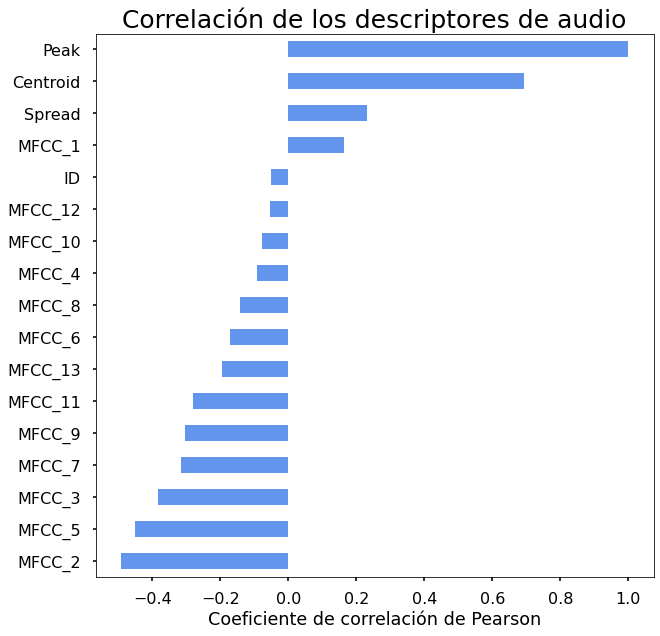

In [54]:
datos.corrwith(datos.Peak).sort_values().plot.barh(figsize=(10,10), color='cornflowerblue')
plt.xlabel('Coeficiente de correlación de Pearson')
plt.title('Correlación de los descriptores de audio', fontsize = 25);

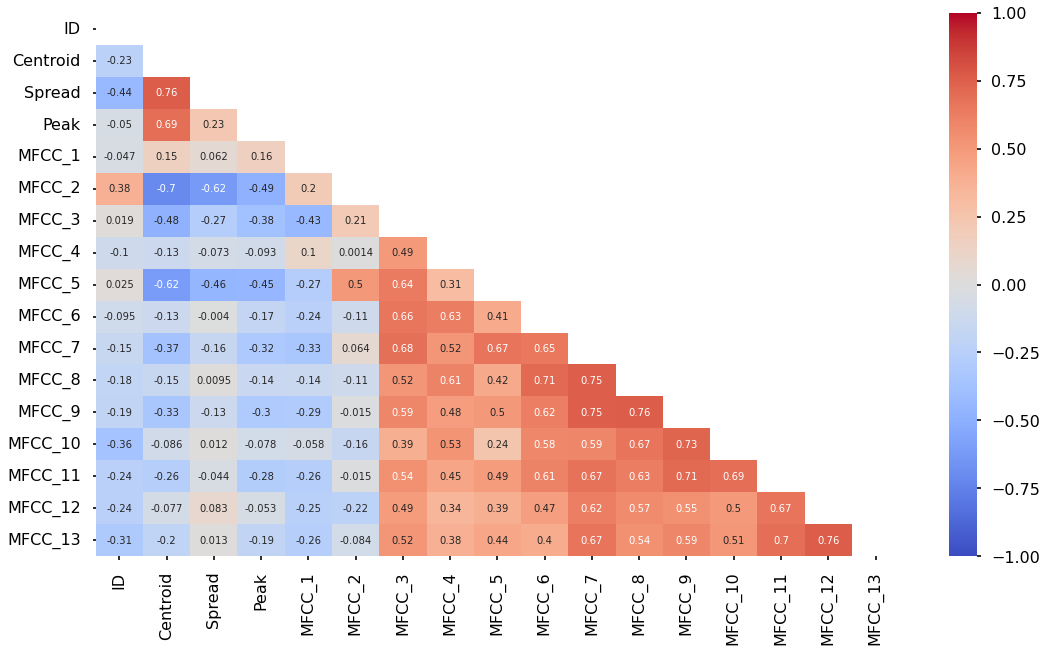

In [55]:
plt.figure(figsize=(18,10))
corr_df = datos.corr()
mask = np.triu(np.ones_like(corr_df))
sns.heatmap(datos.corr(),cmap='coolwarm',annot=True, annot_kws={'fontsize':10}, mask=mask, vmin=-1, vmax=1);

### SEE SOME DATA

In [56]:
plt.style.use("seaborn-poster")

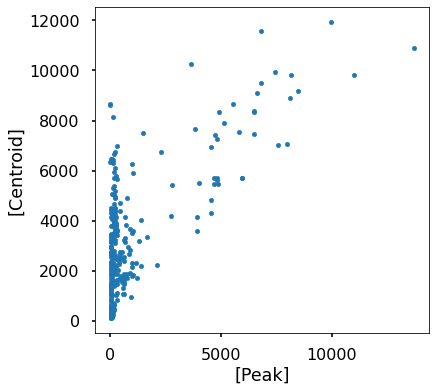

In [57]:
datos[['Peak', 'Centroid']].plot.scatter(x=['Peak'], y=['Centroid'], alpha=1, figsize=(6,6));

### DEFINE X NAMES FOR TRAINING

In [58]:
x_names = ['Centroid', 'Spread', 'Peak', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13']

### SPLIT TRAIN AND TEST DATA

In [59]:
x_train, x_test, y_train, y_test = train_test_split(datos[x_names], datos.ID, test_size=0.2, random_state=69)

In [60]:
from sklearn.model_selection import GridSearchCV
param = {'max_depth':range(2,15)} #, 'criterion':['gini','entropy']} # a modo de diccionario los metaparemetros y valores
dt = DecisionTreeClassifier() # estimador el modelo
clf =  GridSearchCV(dt, param, cv=3) # pendiente explicar Cross-Validation
clf.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 15)})

In [61]:
cv_result = pd.DataFrame(clf.cv_results_)
cv_result#[cv_result.rank_test_score==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002718,0.000297,0.001368,0.000142,2,{'max_depth': 2},0.4500,0.4375,0.4625,0.450000,0.010206,13
1,0.002674,0.000208,0.001283,0.000102,3,{'max_depth': 3},0.6500,0.6375,0.7125,0.666667,0.032808,12
2,0.002383,0.000140,0.000973,0.000024,4,{'max_depth': 4},0.6875,0.6500,0.7375,0.691667,0.035843,11
3,0.002426,0.000085,0.001068,0.000105,5,{'max_depth': 5},0.6875,0.6875,0.7125,0.695833,0.011785,9
4,0.002451,0.000246,0.001108,0.000172,6,{'max_depth': 6},0.6875,0.6875,0.7125,0.695833,0.011785,9
5,0.002251,0.000359,0.000876,0.000177,7,{'max_depth': 7},0.7375,0.6750,0.7125,0.708333,0.025685,7
6,0.001876,0.000032,0.000705,0.000028,8,{'max_depth': 8},0.7250,0.6625,0.7125,0.700000,0.027003,8
7,0.001819,0.000090,0.000668,0.000019,9,{'max_depth': 9},0.7375,0.6750,0.7250,0.712500,0.027003,4
8,0.001692,0.000008,0.000647,0.000041,10,{'max_depth': 10},0.7375,0.7625,0.7375,0.745833,0.011785,1
9,0.001706,0.000069,0.000708,0.000047,11,{'max_depth': 11},0.7125,0.7000,0.7250,0.712500,0.010206,4


### TRAIN WITH RANDOM FOREST

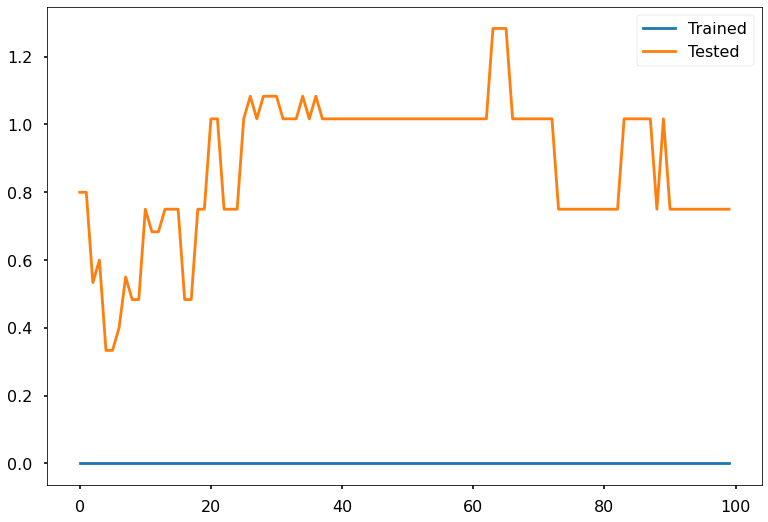

In [196]:
rf = RandomForestClassifier(n_estimators= 20, 
                             max_depth = 10, 
                             random_state = 20)

trained = []
tested = []

for iter in range(100):
    rf.fit(x_train, y_train)
    y_train_predicted = rf.predict(x_train)
    y_test_predicted = rf.predict(x_test)
    mse_train = mean_squared_error(y_train, y_train_predicted)
    mse_test = mean_squared_error(y_test, y_test_predicted)
    trained.append(mse_train)
    tested.append(mse_test)
    #print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    rf.n_estimators += 1

line1, = plt.plot(trained, label='Trained')
line2, = plt.plot(tested, label='Tested')
plt.legend(handles=[line1, line2])

In [197]:
clf = RandomForestClassifier(n_estimators= 20, 
                             max_depth = 10, 
                             random_state = 20)
#clf = RandomForestClassifier(n_estimators=1)
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=20)

In [198]:
y_results_RandomForest = clf.predict(x_test)

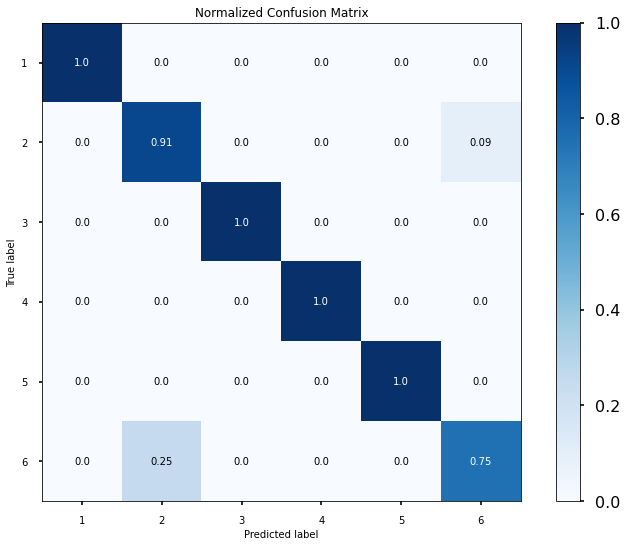

In [199]:
skplt.metrics.plot_confusion_matrix(y_test,y_results_RandomForest, normalize = True);

In [114]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0
guitarAcertados, numGuitar = 0, 0
bassAcertados, numBass = 0, 0
voxAcertados, numVox = 0, 0

for num in range(len(y_results_RandomForest)):
    if x_test.index[num] <= 49:
        if y_results_RandomForest[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_RandomForest[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99 and x_test.index[num] <= 149:
        if y_results_RandomForest[num] == 3:
            hihatAcertados += 1
        numHihat += 1
        
    elif x_test.index[num] > 149 and x_test.index[num] <= 199:
        if y_results_RandomForest[num] == 4:
            guitarAcertados += 1
        numGuitar += 1
        
    elif x_test.index[num] > 199 and x_test.index[num] <= 249:
        if y_results_RandomForest[num] == 5:
            bassAcertados += 1
        numBass += 1
        
    elif x_test.index[num] > 249:
        if y_results_RandomForest[num] == 6:
            voxAcertados += 1
        numVox += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihats", hihatAcertados, "predijo como hihat")
print("De", numGuitar, "Guitars", guitarAcertados, "predijo como guitar")
print("De", numBass, "Basses", bassAcertados, "predijo como Bass")
print("De", numVox, "Voxes", voxAcertados, "predijo como Vox")

De 11 kicks 11 predijo como kick
De 11 Snares 10 predijo como snare
De 8 Hihats 8 predijo como hihat
De 9 Guitars 9 predijo como guitar
De 13 Basses 13 predijo como Bass
De 8 Voxes 6 predijo como Vox


## TRAIN WITH DECISIONS TREE

In [81]:
model_tree = DecisionTreeClassifier(max_depth=11)
model_tree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=11)

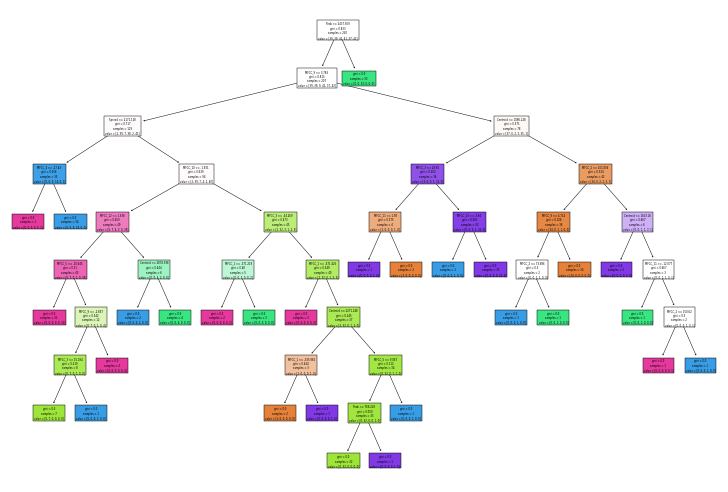

In [82]:
plt.figure()
plot_tree(model_tree, filled=True, feature_names= x_names)
plt.show()

### MAKE AND TEST PREDICTIONS

In [83]:
y_results_tree = model_tree.predict(x_test)
y_results_tree

array([6, 6, 1, 5, 5, 2, 2, 1, 3, 4, 5, 1, 6, 3, 1, 5, 5, 5, 6, 3, 1, 5,
       4, 4, 3, 4, 1, 2, 2, 4, 1, 4, 3, 1, 5, 3, 2, 6, 1, 3, 5, 6, 5, 4,
       3, 1, 1, 3, 6, 5, 3, 1, 4, 2, 5, 1, 4, 2, 4, 2])

In [84]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0
guitarAcertados, numGuitar = 0, 0
bassAcertados, numBass = 0, 0
voxAcertados, numVox = 0, 0

for num in range(len(y_results_tree)):
    if x_test.index[num] <= 49:
        if y_results_tree[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_tree[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99 and x_test.index[num] <= 149:
        if y_results_tree[num] == 3:
            hihatAcertados += 1
        numHihat += 1
        
    elif x_test.index[num] > 149 and x_test.index[num] <= 199:
        if y_results_tree[num] == 4:
            guitarAcertados += 1
        numGuitar += 1
        
    elif x_test.index[num] > 199 and x_test.index[num] <= 249:
        if y_results_tree[num] == 5:
            bassAcertados += 1
        numBass += 1
        
    elif x_test.index[num] > 249:
        if y_results_tree[num] == 6:
            voxAcertados += 1
        numVox += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihats", hihatAcertados, "predijo como hihat")
print("De", numGuitar, "Guitars", guitarAcertados, "predijo como guitar")
print("De", numBass, "Basses", bassAcertados, "predijo como Bass")
print("De", numVox, "Voxes", voxAcertados, "predijo como Vox")

De 11 kicks 11 predijo como kick
De 11 Snares 6 predijo como snare
De 8 Hihats 6 predijo como hihat
De 9 Guitars 8 predijo como guitar
De 13 Basses 12 predijo como Bass
De 8 Voxes 5 predijo como Vox


In [85]:
print(classification_report(y_test,y_results_tree))

              precision    recall  f1-score   support

           1       0.85      1.00      0.92        11
           2       0.75      0.55      0.63        11
           3       0.60      0.75      0.67         8
           4       0.80      0.89      0.84         9
           5       1.00      0.92      0.96        13
           6       0.71      0.62      0.67         8

    accuracy                           0.80        60
   macro avg       0.79      0.79      0.78        60
weighted avg       0.80      0.80      0.80        60



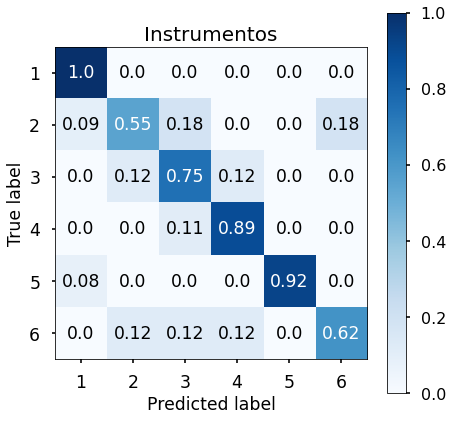

In [86]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_tree, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

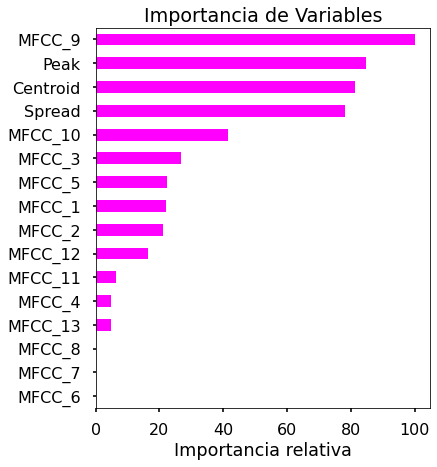

In [87]:
#DF de variables mas importantes
f_imp = pd.DataFrame(model_tree.feature_importances_,
                     index=x_names, columns=['imp'])
#calculo de importancia relativa
f_imp['imp_rel'] = (f_imp/f_imp.max()*100)
#plot de importancia de variables
f_imp.sort_values('imp_rel',ascending=True).imp_rel.plot.barh(figsize=(6,7),
                                                              title='Importancia de Variables',color='magenta')
plt.xlabel('Importancia relativa');

## TRAIN WITH LOGICTIC REGRESSION

### STANDARIZE DATA

In [31]:
# estandarizado
x_train = (x_train - x_train.mean())/x_train.std()
x_test = (x_test - x_test.mean())/x_test.std()

### TRAIN MODEL

In [32]:
# Entrenamiento del modelo
model = LogisticRegression(solver="liblinear")
model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

### MAKE AND TEST PREDICTIONS

In [33]:
y_results_logictic = model.predict(x_test)

In [34]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0

for num in range(len(x_test)):
    if x_test.index[num] <= 49:
        if y_results_logictic[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_logictic[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99:
        if y_results_logictic[num] == 3:
            hihatAcertados += 1
        numHihat += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihat", hihatAcertados, "predijo como hihat")

De 10 kicks 10 predijo como kick
De 8 Snares 6 predijo como snare
De 12 Hihat 11 predijo como hihat


### PREDICTIONS PROBABILITIES

In [35]:
y_hat_proba = model.predict_proba(x_test)
y_hat_proba[:10]

array([[8.83571115e-01, 3.14857281e-02, 8.49431568e-02],
       [3.25486838e-03, 4.48359661e-01, 5.48385471e-01],
       [8.65498487e-01, 1.30862335e-01, 3.63917846e-03],
       [3.11317693e-04, 4.43570804e-01, 5.56117878e-01],
       [8.00558046e-01, 1.97999867e-01, 1.44208779e-03],
       [7.29646507e-01, 2.68116533e-01, 2.23695990e-03],
       [4.33167393e-01, 5.48074289e-01, 1.87583178e-02],
       [1.79842631e-02, 5.94903403e-02, 9.22525397e-01],
       [8.74253789e-02, 1.30310583e-02, 8.99543563e-01],
       [7.67537848e-01, 2.30018981e-01, 2.44317109e-03]])

In [36]:
print(classification_report(y_test,y_results_logictic))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.86      0.75      0.80         8
           3       0.85      0.92      0.88        12

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.89        30
weighted avg       0.90      0.90      0.90        30



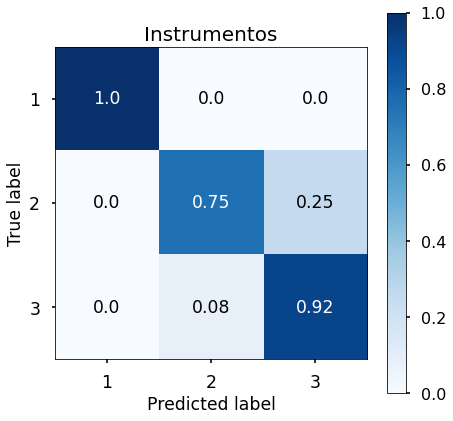

In [37]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_logictic, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

In [90]:
#print('Área bajo la curva ROC:',"% 1.3f" % roc_auc_score(y_test, y_hat, multi_class='ovr'))